In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sb

# ETL

In [2]:
df=pd.read_csv('/Users/ruhidmirzayev/Palette/Data/rm-yields-data.csv')

In [3]:
gdf=gpd.read_file('/Users/ruhidmirzayev/Palette/Data/RuralMunicipality/RuralMunicipality.shp')

In [4]:
gdf['RMNO']=gdf['RMNO'].astype('int').astype('string')

## Scoping

What problem I will solve?

## Data Collections

In [5]:
df['Canola']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
25307    39.3
25308    46.1
25309    40.9
25310    23.9
25311    44.4
Name: Canola, Length: 25312, dtype: float64

In [6]:
ds= pd.DataFrame()

ds['Canola Mean']=df.loc[(df['Year'] > 2012) & (df['Year'] <= 2022)].groupby('RM').mean()['Canola']
ds['Canola Std']=df.loc[(df['Year'] > 2012) & (df['Year'] <= 2022)].groupby('RM').std()['Canola']

In [7]:
ds = ds.reset_index()

In [8]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RM           295 non-null    int64  
 1   Canola Mean  295 non-null    float64
 2   Canola Std   294 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 7.0 KB


In [9]:
ds['RM']=ds['RM'].astype('string')

In [10]:
gds = gpd.GeoDataFrame(pd.merge(ds, gdf.rename(columns={'RMNO':'RM'})[['RM', 'geometry']], on='RM'))

In [11]:
gds=gds.loc[gds['RM']!='521']

<AxesSubplot:>

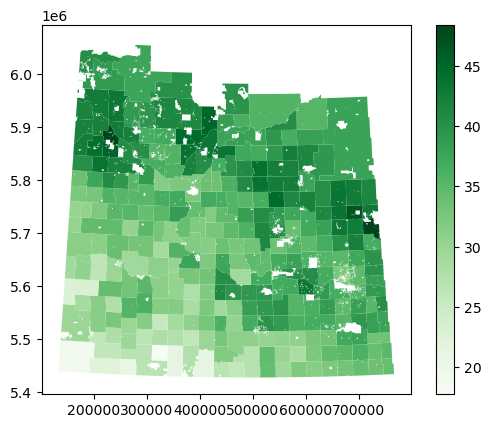

In [12]:
gds.plot('Canola Mean', legend=True, cmap='Greens')

<AxesSubplot:>

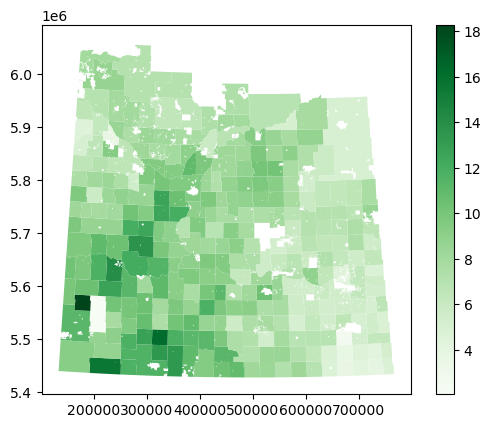

In [13]:
gds.plot('Canola Std', legend=True, cmap='Greens')

In [14]:
gds.isna().sum()

RM             0
Canola Mean    0
Canola Std     1
geometry       0
dtype: int64

In [16]:
df.loc[(df['RM']==279) & (df['Year'] > 2012)]['Canola'].isna()

14340    False
14341     True
14342     True
14343     True
14344     True
14345     True
14346     True
14347     True
14348     True
14349     True
Name: Canola, dtype: bool

In [24]:
ds

,RM,Canola Mean,Canola Std
0,1,34.035,4.714758
1,2,33.515,4.058955
2,3,34.103,4.238863
3,4,33.095,3.796540
4,5,32.304,4.659574
...,...,...,...
290,520,39.783,7.413043
291,555,40.092,7.145617
292,561,38.856,8.582959
293,588,37.569,7.127076


In [25]:
ds=ds.dropna()

In [26]:
ds.isna().sum()

RM             0
Canola Mean    0
Canola Std     0
dtype: int64

<AxesSubplot:>

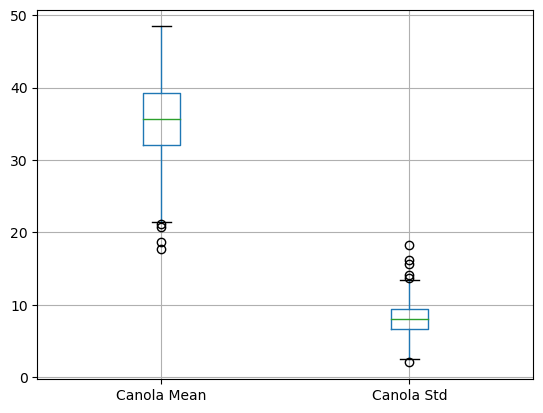

In [29]:
ds.boxplot()

In [32]:
from scipy.stats import zscore # (std - mean) / std data standardization

In [50]:
zscore(ds.set_index('RM')).sort_values('Canola Mean') 
# In case of normal distribution

# 68% data is located -1 and 1
# 95% is located -2 and 2
# 98% is located -3 and 3

,Canola Mean,Canola Std
RM,,
46,-3.392800,2.348478
51,-3.200675,0.488964
18,-2.818650,1.621671
43,-2.748206,0.580169
45,-2.672744,2.314223
...,...,...
493,1.856447,-0.322290
439,1.880692,0.562853
303,2.153306,-0.614008


<AxesSubplot:xlabel='Year'>

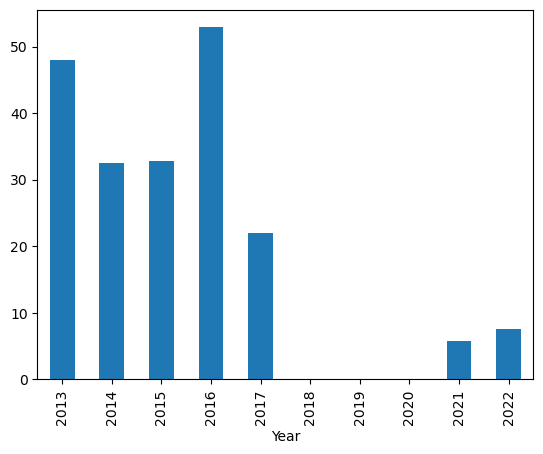

In [47]:
df.loc[(df['RM']== 141) & (df['Year'] > 2012)]\
    .set_index('Year')\
    ['Canola'].plot(kind = 'bar')

array([[<AxesSubplot:title={'center':'Canola Mean'}>,
        <AxesSubplot:title={'center':'Canola Std'}>]], dtype=object)

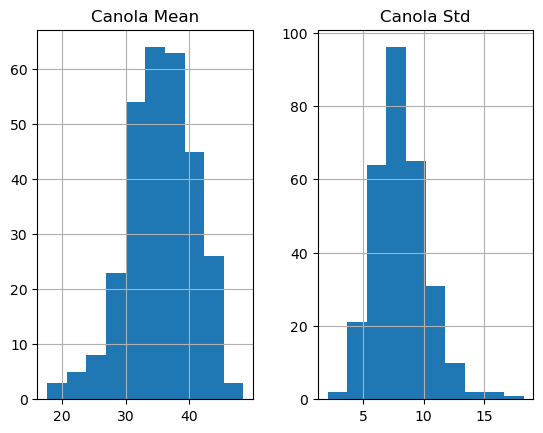

In [49]:
ds.hist()

In [60]:
ds.isna().sum()

RM             0
Canola Mean    0
Canola Std     0
dtype: int64

# Unsuoervised Machile Learning

## K Means

In [57]:
# Importing library
from sklearn.cluster import KMeans 

# Let's define our features
X = ds.set_index('RM')

from sklearn.metrics import silhouette_score
n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15] # number of clusters
clusters_inertia = [] # inertia of clusters
s_scores = [] # silhouette scores

for n in n_clusters:
    KM = KMeans(n_clusters=n, init='k-means++').fit(X)
    clusters_inertia.append(KM.inertia_)    # data for the elbow method
    silhouette_avg = silhouette_score(X, KM.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

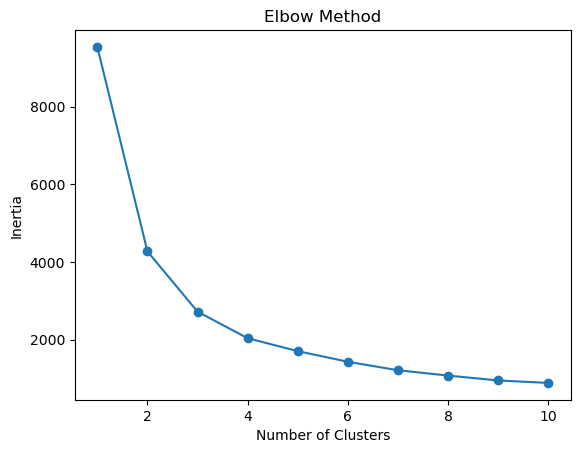

In [70]:
max_clusters = 10

# Perform K-means clustering for different number of clusters
inertia = []
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

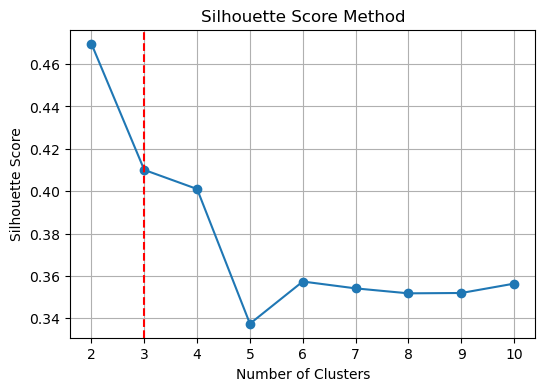

In [110]:
# Set the range of clusters to test
min_clusters = 2
max_clusters = 10

# Perform K-means clustering for different number of clusters
n_clusters = range(min_clusters, max_clusters + 1)
s_scores = []
for k in n_clusters:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(X)
    s_score = silhouette_score(X, labels)
    s_scores.append(s_score)

# Plot the silhouette scores
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(n_clusters, s_scores, marker='o')
ax.set_title("Silhouette Score Method")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")
ax.axvline(3, ls="--", c="red")
ax.grid(True)
plt.show()

In [78]:
# Cluster 3
df_3_clusters = KMeans(n_clusters=3, init='k-means++').fit(X) # initialise and fit K-Means model

df_3= X.copy()
df_3.loc[:,'Cluster_4'] = df_3_clusters.labels_ # append labels to points

# Clusters 4
df_4_clusters = KMeans(n_clusters=4, init='k-means++').fit(X) # initialise and fit K-Means model

df_4= X.copy()
df_4.loc[:,'Cluster_4'] = df_4_clusters.labels_ # append labels to points

# Clusters 5
df_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X) # initialise and fit K-Means model

df_5= X.copy()
df_5.loc[:,'Cluster_4'] = df_5_clusters.labels_ # append labels to points

In [83]:
gdf[['RMNO', 'geometry']].rename(columns = {'RMNO': 'RM'})

,RM,geometry
0,95,"POLYGON ((654081.000 5546088.320, 654885.320 5..."
1,378,"POLYGON ((265258.740 5810148.180, 266062.740 5..."
2,288,"POLYGON ((254141.490 5701256.420, 254179.510 5..."
3,106,"POLYGON ((339874.810 5539057.770, 339849.430 5..."
4,132,"POLYGON ((445175.620 5573313.600, 445572.880 5..."
...,...,...
293,588,"MULTIPOLYGON (((307104.520 6003527.820, 307139..."
294,352,"POLYGON ((187054.680 5758478.840, 187005.860 5..."
295,351,"POLYGON ((209380.850 5785495.100, 209851.950 5..."
296,520,"MULTIPOLYGON (((451283.150 5981138.420, 451285..."


<AxesSubplot:>

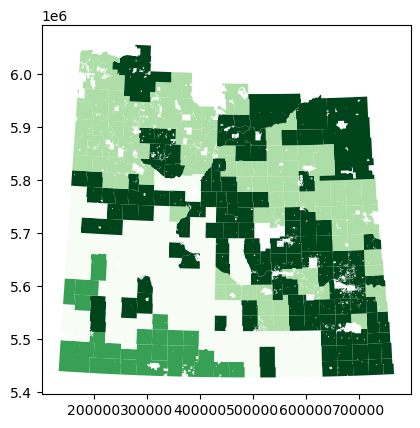

In [108]:
gpd.GeoDataFrame(pd.merge(
    df_4,
    gdf[['RMNO', 'geometry']].rename(columns = {'RMNO': 'RM'}),
     on='RM' )).plot('Cluster_4', cmap='Greens', scheme='naturalbreaks', k=4)

In [96]:
df_4.groupby('Cluster_4').mean()

,Canola Mean,Canola Std
Cluster_4,,
0,31.025479,9.369612
1,41.489669,7.579458
2,24.496224,11.745245
3,35.786570,7.110033


In [97]:
df_4.groupby('Cluster_4')\
    .mean()\
    .sort_values('Canola Mean')

,Canola Mean,Canola Std
Cluster_4,,
2,24.496224,11.745245
0,31.025479,9.369612
3,35.786570,7.110033
1,41.489669,7.579458


In [101]:
df_4['Cl_4']=df_4['Cluster_4'].replace(to_replace={
    2:0,
    0:1,
    3:2,
    1:3
})

In [102]:
df_4

,Canola Mean,Canola Std,Cluster_4,Cl_4
RM,,,,
1,34.035,4.714758,3,2
2,33.515,4.058955,3,2
3,34.103,4.238863,3,2
4,33.095,3.796540,3,2
5,32.304,4.659574,3,2
...,...,...,...,...
520,39.783,7.413043,1,3
555,40.092,7.145617,1,3
561,38.856,8.582959,1,3


<AxesSubplot:>

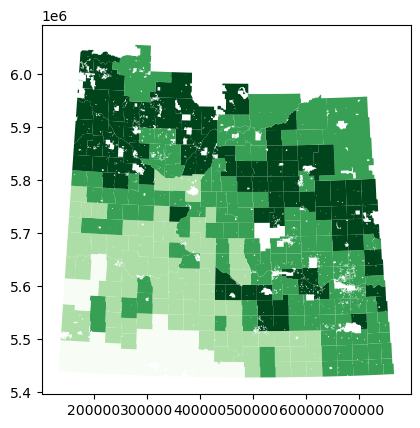

In [106]:
gpd.GeoDataFrame(pd.merge(
    df_4,
    gdf[['RMNO', 'geometry']].rename(columns = {'RMNO': 'RM'}),
     on='RM' )).plot('Cl_4', cmap='Greens', scheme='naturalbreaks', k=4)

In [104]:
gpd.GeoDataFrame(pd.merge(
    df_4,
    gdf[['RMNO', 'geometry']].rename(columns = {'RMNO': 'RM'}),
     on='RM' )).to_file('/Users/ruhidmirzayev/Canola_rm_clustering.geojson', driver='GeoJSON')